<a href="https://colab.research.google.com/github/atlanticstarr1/mnist/blob/main/mnist_resnet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# REFERENCES (REALLY GOOD)
# https://keras.io/examples/vision/consistency_training/
# https://github.com/keras-team/keras-io/blob/master/examples/vision/adamatch.py
# https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/adamatch.ipynb

In [3]:
%pip install keras-cv
%pip install --upgrade tensorflow
%pip install tensorflow-addons
%pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow_addons as tfa #maybe remove (SWA increases training time hugely)
import tensorflow_datasets as tfds
from keras import layers,regularizers
from keras_cv.layers import RandAugment
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,classification_report, confusion_matrix

In [5]:
# Load dataset
tfds.disable_progress_bar()
(test_set, valid_set, train_set) ,info= tfds.load("mnist", split=["test", "train[:10%]", "train[10%:]"],as_supervised=True, with_info=True)
# Extract informative features
class_names = info.features["label"].names
num_classes = info.features["label"].num_classes

In [6]:
## Define constants and hyperparameters
RESIZE_TO = 32
BATCH_SIZE = 128
EPOCHS = 50
AUTO = tf.data.AUTOTUNE
LEARNING_RATE = 0.03

In [7]:
# Initialize `RandAugment`
augmenter = RandAugment(
    value_range=(0, 1),
    augmentations_per_image=3,
    magnitude=0.9,
    magnitude_stddev=0.2,
    rate=0.5,
)

In [8]:
def to_dict(image, label):
    # convert MNIST images to RGB
    # normalize image to [0,1] and one-hot encode labels
    image = tf.image.resize_with_pad(image, RESIZE_TO, RESIZE_TO)
    image = tf.tile(image, [1, 1, 3])
    image = tf.cast(image, tf.float32)/255
    label = tf.one_hot(label, num_classes)
    return image,label

def prepare_dataset(dataset, split, augment):
    dataset = dataset.map(to_dict, num_parallel_calls=AUTO)
    if split == "train":
        dataset = dataset.shuffle(10 * BATCH_SIZE)
    if augment:
        dataset = dataset.map(lambda x,y:(augmenter(x),y), num_parallel_calls=AUTO)
    return dataset.batch(BATCH_SIZE).prefetch(AUTO)

def load_dataset(split="train", augment=False):
    if split =='train':
        dataset = train_set
    if split =='test':
        dataset = test_set
    if split =='validation':
        dataset = valid_set
    return prepare_dataset(dataset, split, augment)

Generate datasets

In [9]:
train_dataset = load_dataset()
train_dataset_aug = load_dataset(augment=True)
val_dataset = load_dataset(split="validation")
test_dataset = load_dataset(split="test")

Inspect some samples from our dataset

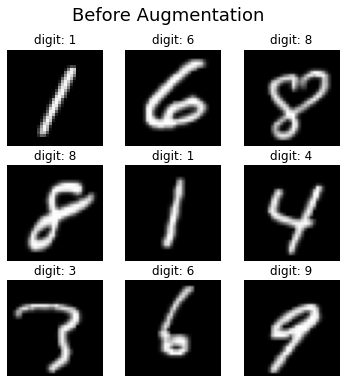

In [10]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, (images,labels) in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.title("digit: {}".format(np.argmax(labels[0])))
        plt.imshow(images[0])
        plt.axis("off")
    plt.show()

visualize_dataset(train_dataset, title="Before Augmentation")

Visualize after RandAugment

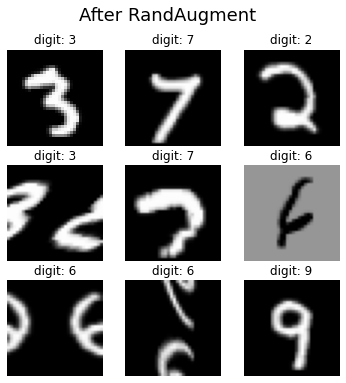

In [11]:
visualize_dataset(train_dataset_aug, title="After RandAugment")

In [12]:
# Define a model building utility function (ResNet50V2 architecture)
def get_training_model(num_classes=num_classes):
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights=None, include_top=False, input_shape=(RESIZE_TO, RESIZE_TO, 3),
    )
    model = tf.keras.Sequential(
        [
            layers.Input((RESIZE_TO, RESIZE_TO, 3)),
            layers.Rescaling(scale=1.0 / 255.0),
            resnet50_v2,
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes),
        ]
    )
    return model

In [13]:
# save initial weights
initial_teacher_model = get_training_model()
initial_teacher_model.save_weights("initial_teacher_model.h5")

In [14]:
## TRAIN THE MODEL

# Initialize SWA from tensorflow
SWA = tfa.optimizers.SWA

# Compile and train the teacher model.
teacher_model = get_training_model()
teacher_model.load_weights("initial_teacher_model.h5")
teacher_model.compile(
    # Wrap optimizer within SWA
    optimizer=Adam(),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

#teacher_model.summary()

# Define the callbacks.
model_checkpoint = ModelCheckpoint(
    filepath='final_teacher_model.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [ReduceLROnPlateau(patience=3),EarlyStopping(patience=10, restore_best_weights=True),model_checkpoint]

start = time.perf_counter()

history = teacher_model.fit(
    train_dataset_aug,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
)

duration = time.perf_counter()-start
hrs=int(duration/3600)
mins=int((duration-hrs*3600)/60)
secs= duration-hrs*3600-mins*60
msg='The training cycle took {0} hours {1} minutes and{2:6.2f} seconds'
print(msg.format(hrs, mins,secs))

Epoch 1/50
211/211 [==============================] - 209s 944ms/step - loss: 0.9042 - accuracy: 0.7136 - val_loss: 3.0499 - val_accuracy: 0.1035 - lr: 0.0010
Epoch 2/50
130/211 [=================>............] - ETA: 1:14 - loss: 0.5404 - accuracy: 0.8194

KeyboardInterrupt: 

In [ ]:
# plot loss during training
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True, figsize=(8,8))
ax1.set_title("model loss")
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['training', 'validation'],loc='best')
ax1.set_ylabel('loss')
# plot accuracy during training
ax2.set_title("model accuracy")
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['training', 'validation'], loc='best')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
plt.show()

In [ ]:
# Evaluate the teacher model on the test set.
_,acc = teacher_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy: {acc * 100:.2f}%")

In [ ]:
# Generate predictions
y_pred = teacher_model.predict(test_dataset,verbose=0)
y_pred = y_pred.argmax(axis=1) # predicted labels
y_true = np.concatenate([y for x,y in test_dataset]).argmax(axis=1) # true labels

In [ ]:
# Evaluate predictions
acc = accuracy_score(y_true, y_pred)
precision =precision_score(y_true,y_pred,average="macro")
recall =recall_score(y_true,y_pred,average="macro")
f1score =f1_score(y_true,y_pred,average="macro")
print("Accuracy = %4.4f" %acc)
print("Precision = %4.4f" %precision)
print("Recall = %4.4f" %recall)
print("F1-score = %4.4f" %f1score)

In [ ]:
print(classification_report(y_true, y_pred, digits=4))

In [ ]:
pd.DataFrame(confusion_matrix(y_true, y_pred))